<a href="https://colab.research.google.com/github/sumerberksener/Classifying-Disaster-Related-Tweets-as-Real-or-Fake/blob/main/Classifying_Disaster_Related_Tweets_as_Real_or_Fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Disaster-Related Tweets as Real or Fake
In this proeject I will train several NLP models to classify the tweets as real or fake. The tweets in the dataset are all disaster related.

I will start by performing the usual data cleaning and visualisation techniques on the data. I will create four NLP models:
1. Shallow neural network
2. Multilayer text classification model.
3. Multilayer bidirectional model
4. NLP model using transformers

I am expecting to obtain the best accuracy score using the transformer model.

## Introduction
Start by importing the necessary libraries.


In [1]:
# install the datasets library
!pip install datasets
!pip install transformers

# import the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalAveragePooling1D
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load the dataset and inspect the first and last five rows.

In [2]:
# load the train dataset
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
train = pd.read_csv('train.csv')

--2023-12-12 02:45:36--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 16.182.33.153, 3.5.29.130, 52.216.220.1, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|16.182.33.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/csv]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>] 964.56K  5.45MB/s    in 0.2s    

2023-12-12 02:45:36 (5.45 MB/s) - ‘train.csv.2’ saved [987712/987712]



In [4]:
# examine the first and last five rows of the dataset
train.head()
train.tail()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
# examine the shape of the dataset
train.shape

(7613, 5)

In [6]:
# print the information about the cols
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The data seems to have missing values in some of the columns, count the number of missing values in these columns.

In [7]:
# count the number of missing values in the cols
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The `keyword` columns has 61 missing values and the `location` column has 2533 missing values. We will need to find a way of dealing with these missing values.

In [8]:
# unique values in each of the cols
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

We can see that the keywords are generally repeated in the tweets. The fact that there are so many unique locations means that the location probablly doesn't have that much predictive power when it comes to predicting whether a tweet is real of fake.

We roughly have two tweets from each location in the `location` column. We might consider dropping this columns given the number of missing values it has coupled with the fact that it has more than 3000 unique values.

## Data Exploration
As we have seen in the previous section, the `location` column has roughly 5000 entries in total, however, just over 3000 of these are unique. Therefore, the `location` column doesn't have that much predictive power and it doesn't contribute much to our model. Thus, we can drop it.

Drop the `id` column and the `keyword` columns as well. The `id` column has no relevance to the content of the message and we don't expect the word in the `keyword` column to be a good predictor for the nature of the message as it cannot capture the context of the message by using a single word.



In [9]:
# drop the location column
train.drop(columns = ['location', 'id', 'keyword'], axis = 1, inplace = True)

In [10]:
# print value_counts of the target variable
train['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

### Countplot Analysis
We have analysed the proportions of the cases and non-cases in the `target` column above. We can improve our analysis by plotting a countplot of each of the columns.

<Axes: xlabel='target', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Cases and Non-cases in the Target Column')

[]

Text(0.5, 0, '')

Text(0, 0.5, '')

[Text(0, 0, '4342'), Text(0, 0, '3271')]

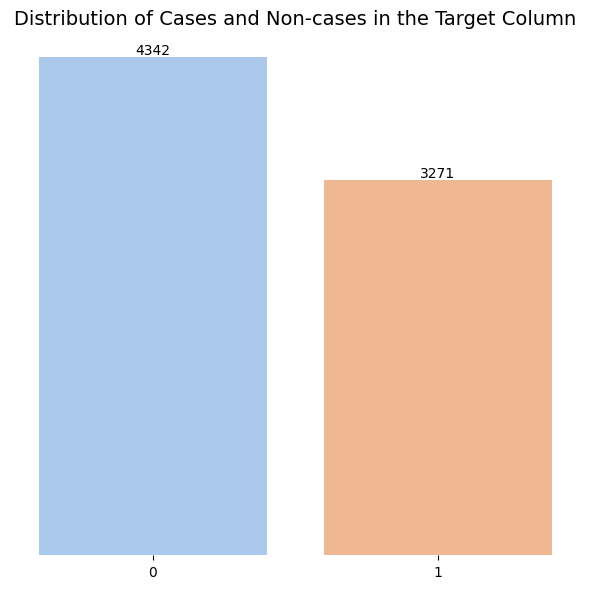

In [11]:
# plot the countplot
fig,ax = plt.subplots(figsize = (6,6))
sns.countplot(data = train,
              x = 'target',
              ax =ax,
              palette = 'pastel',
              order = train['target'].value_counts().index)
ax.set_title('Distribution of Cases and Non-cases in the Target Column', fontsize = 14)
ax.set_yticks([])
ax.set_xlabel('', fontsize = 14)
ax.set_ylabel('')
for container in ax.containers:
  ax.bar_label(container)
for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
plt.tight_layout()

As seen in the countplot above, our data includes less cases than non-cases. However, the numbers are comparable and one of them doesn't massively outnumber the other one. Therefore, our data is balanced and we can keep all of it.

## Text Preprocessing
In this section I will preprocess the text in the tweets to prepare them to be fed into the model. I will transform the text into lowercase and will get rid of punctuation and stopwords.

### Preprocessing the Train Dataset

Start by converting the `text` column to lower case.

In [12]:
#convert the text col into lower case
train['text_lower'] = train['text'].str.lower()

Create a function to remove punctuation and everything that is not a letter or a space character.

In [13]:
# define the punctuation function
def punctuation(inputs):
  return re.sub(r'[^a-zA-Z]', ' ', inputs)

In [14]:
# apply to text column
train['text_punc'] = train['text_lower'].apply(punctuation)

Also, create a function to tokenize the text into individual words and apply this function to the `text` column.

In [15]:
# define the tokenization function
def tokenization(inputs):
  return word_tokenize(inputs)

In [16]:
# tokenize the text col
train['text_token'] = train['text_punc'].apply(tokenization)

Some stopwords will be repeated many times in the text without contributing much to our model. Hence, I will remove these stopwords from the `text` column by creating a function remove the stopwords and applying it to the `text` column.

In [18]:
# define the stop words we want to remove
stop_words = set(stopwords.words('english'))

In [19]:
# define the function to remove stopwords
def stopwords_remove(inputs):
  return [word for word in inputs if word not in stop_words]

In [20]:
# remove the stopwords from the text column
train['text_stop'] = train['text_token'].apply(stopwords_remove)

Our text includes different versions of the same words. For example the words 'run' and 'ran' are counted as different words. However, we really want them to be considered the same. For this I will lemmatise the `text` column.
<br>
I will first create a function to lemmatise the text and then I will apply this function to the `text` column.

In [21]:
# create an instance of the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [22]:
# define the function
def lemmatization(inputs):
  return [lemmatizer.lemmatize(word = word, pos = 'v') for word in inputs]

In [23]:
# lemmatize the text column
train['text_lemmatized'] = train['text_stop'].apply(lemmatization)

Next, we need to join the lemmatized words to form sentences and assign these sentences to a new column `final` in the dataset.

In [24]:
# create the final column
train['final'] = train['text_lemmatized'].str.join(' ')

In [25]:
# chech that the preprocessing was successful
train.head()

,text,target,text_lower,text_punc,text_token,text_stop,text_lemmatized,final
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake m...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,all residents asked to shelter in place are ...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic...",residents ask shelter place notify officer eva...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation or...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation order cali...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as ...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfires pou...


Looking at the first five rows of our dataset, we can see that each step of our word preprocessing has been successful. Moving on, we will be working with the `final` column of the `train` dataset.

## Visualization with WordCloud
In this section I will generate a wordcloud for the words found in real and fake disaster texts to get a feel for how they differ in the vocab they use.

### Real Tweets
I will isolate the real disaster related tweets and will create a wordcloud for them.

In [27]:
# isolate the disaster tweets
tweets_1 = train[train['target'] ==1]

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'WordCloud of Frequently Used Words in Genuine Disaster Tweets')

(-0.5, 399.5, 199.5, -0.5)

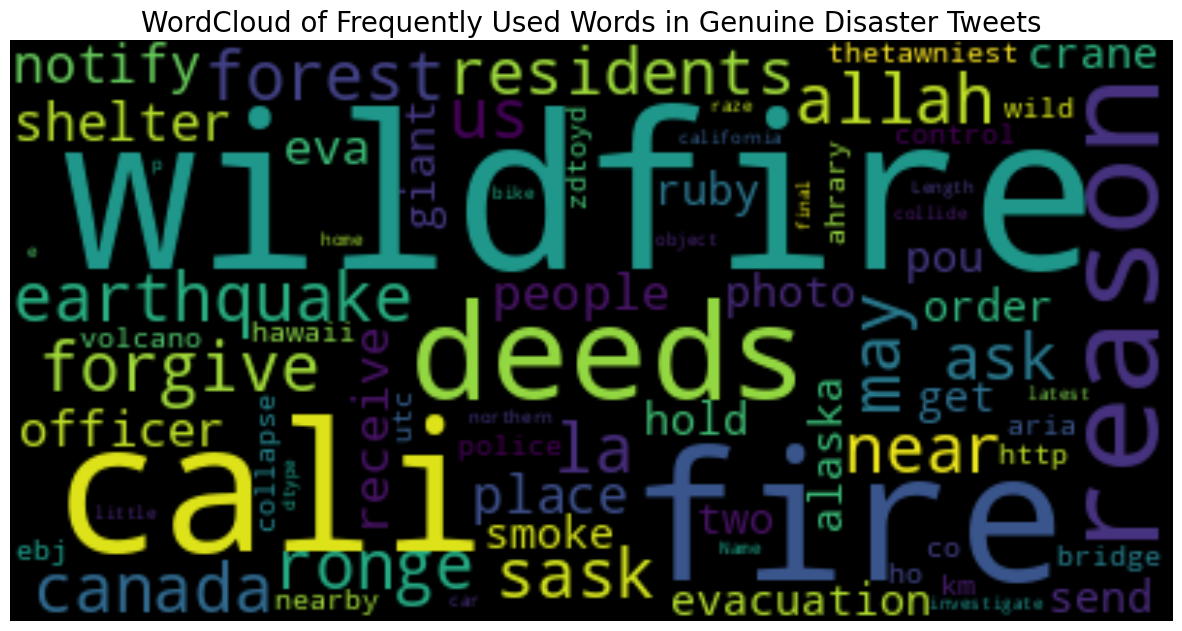

In [28]:
# plot the wordcloud
word_cloud_1 = WordCloud(max_words = 100, stopwords = stop_words, random_state = 100).generate(str((tweets_1['final'])))
plt.figure(figsize = (15,10))
plt.imshow(word_cloud_1, interpolation = 'bilinear')
plt.title('WordCloud of Frequently Used Words in Genuine Disaster Tweets', fontsize = 20)
plt.axis('off')


### Fake Tweets
I will isolate the fake disaster related tweets and will create a wordcloud for them.

In [29]:
# isolate the fake tweets
tweets_0 = train[train['target'] ==0]

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'WordCloud of Frequently Used Words in Fake Disaster Tweets')

(-0.5, 399.5, 199.5, -0.5)

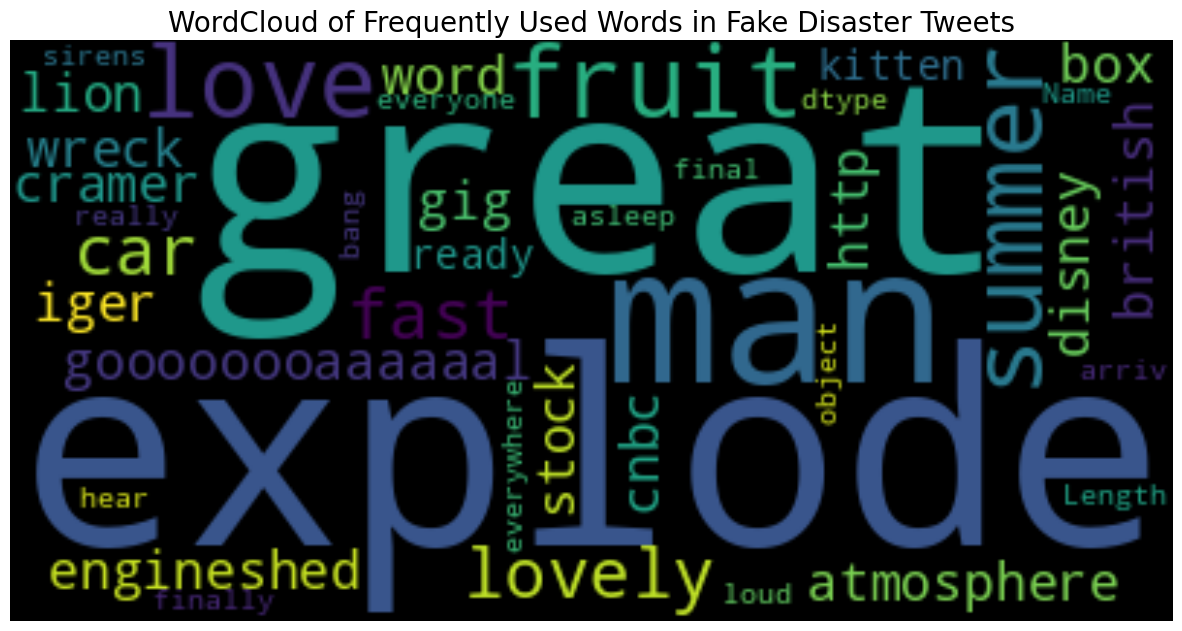

In [30]:
# plot the wordcloud
word_cloud_0 = WordCloud(max_words = 100, stopwords = stop_words, random_state = 100).generate(str((tweets_0['final'])))
plt.figure(figsize = (15,10))
plt.imshow(word_cloud_0, interpolation = 'bilinear')
plt.title('WordCloud of Frequently Used Words in Fake Disaster Tweets', fontsize = 20)
plt.axis('off')


Comparing the word clouds for the fake and real tweets we realise that the fake tweets use much more striking and flashy language, whereas the real tweets seem to be using a more reasonable language. The word cloud for the fake tweets has words like *'explode'* and *'great'*, whereas the word cloud for the genuine disaster related tweets inludes words like *'reason'*, '*wildfire'* and *'Cali'*.

## Build a Shallow Neural Network
In this section I will create a shallow neural network that has a vectorizer layer and an embedding layer. After the embedding layer I will add a fully connected layer with 16 neurons.

I will use the `train` dataset I have cleaned so far to generate my training and testing dataset. I will use a split of 80-20 to generate my training and testing datasets.

In [31]:
# split the data into train and test dataset
data_train = train.sample(frac = 0.8, random_state = 100)
data_test = train.drop(list(data_train.index), axis =0)

X_train = data_train['final']
y_train = data_train['target']
X_test = data_test['final']
y_test = data_test['target']

I have split the data into train and test dataset above. Next, I will create an instance of the Keras Sequential API with a vectorizer and embedding layers.

In [32]:
# create an instance of the model
max_tokens = 20000
output_sequence_length = 256
output_dim = 128

vectorizer_layer = TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    standardize = 'lower_and_strip_punctuation',
    output_sequence_length = output_sequence_length
)

vectorizer_layer.adapt(X_train)

embedding_layer = Embedding(
    input_dim = max_tokens,
    output_dim = output_dim,
    input_length = output_sequence_length
)

model = Sequential()
model.add(Input(shape = (1,), dtype = tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(layers.Dense(16, activation ='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
opt = tf.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs =10)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'The test accuracy is: {test_acc}')


Epoch 1/10
191/191 [==============================] - 32s 57ms/step - loss: 0.6805 - accuracy: 0.5811
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.6783 - accuracy: 0.5857
Epoch 3/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6736 - accuracy: 0.5861
Epoch 4/10
191/191 [==============================] - 2s 8ms/step - loss: 0.6716 - accuracy: 0.5863
Epoch 5/10
191/191 [==============================] - 2s 8ms/step - loss: 0.6723 - accuracy: 0.5795
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.6712 - accuracy: 0.5863
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.6709 - accuracy: 0.5865
Epoch 8/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6708 - accuracy: 0.5865
Epoch 9/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6707 - accuracy: 0.5866
Epoch 10/10
191/191 [==============================] - 1s 8ms/step - loss: 0.6708 - accuracy: 0

48/48 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.5486
The test accuracy is: 0.5485549569129944


Our shallow neural network achieved an accuracy score of 0.55, this is marginally better than taking a random guess. In the upcoming model I will try to improve the accuracy score by adding additional layers.

## Build a Multilayer Deep Text Classification Model
In this section I will improve on my previous model by adding a dropout layer and using techniques like regularization.

In [43]:
# create an instance of the Sequential API
model = Sequential()
model.add(Input(shape = (1,), dtype = tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation = 'elu', kernel_regularizer = L1(0.0005)))
model.add(Dropout(0.6))
model.add(Dense(64, activation = 'elu', kernel_regularizer = L1(0.0005)))
model.add(Dense(32, activation = 'elu', kernel_regularizer = L1L2(0.0005)))
model.add(Dense(16, activation = 'elu', kernel_regularizer = L2(0.0005)))
model.add(Dense(8, activation = 'elu', kernel_regularizer = L2(0.0005)))
model.add(Dense(1, activation = 'sigmoid'))
opt= tf.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, epochs = 10)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'The test accuracy is : {test_acc}')



Epoch 1/10
191/191 [==============================] - 15s 58ms/step - loss: 1.7510 - accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 1.6120 - accuracy: 0.6138
Epoch 3/10
191/191 [==============================] - 4s 23ms/step - loss: 1.4520 - accuracy: 0.7350
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 1.1906 - accuracy: 0.9028
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.9764 - accuracy: 0.9438
Epoch 6/10
191/191 [==============================] - 2s 8ms/step - loss: 0.8770 - accuracy: 0.9525
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.8129 - accuracy: 0.9578
Epoch 8/10
191/191 [==============================] - 2s 10ms/step - loss: 0.7608 - accuracy: 0.9626
Epoch 9/10
191/191 [==============================] - 2s 12ms/step - loss: 0.7191 - accuracy: 0.9658
Epoch 10/10
191/191 [==============================] - 3s 17ms/step - loss: 0.6921 - accurac

48/48 [==============================] - 1s 3ms/step - loss: 1.1732 - accuracy: 0.7735
The test accuracy is : 0.7734733819961548


We have obtained an accuracy of 0.77 using the multilayer model. This is a significant improvement over the previous shallow neural network.

## Building a Multilayer Bidirectional LSTM Model
I will add multiple Bidirectional LSTM layers with different units after the embedding layer in hopes of improving the model. Moreover, I will use higher parameters for regularization in hopes of preventing overfitting.

I will choose a different optimizer for my model this time: `RMSprop` optimizer. The `learning_rate` parameter will be set to 0.0001 which should be ringing alarm bells because this could mean our data could be prone to overfitting and perhaps may not generalise well to unseen data.

In [34]:
# create a multilayer bidirectional LSTM model
model = Sequential()
model.add(Input(shape = (1,), dtype = tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(8, return_sequences = True), merge_mode = 'sum'))
model.add(Bidirectional(LSTM(4, return_sequences = True), merge_mode = 'mul'))
model.add(Bidirectional(LSTM(4)))
model.add(Dense(8, activation = 'elu', kernel_regularizer = L1L2(0.1)))
model.add(Dense(8, activation = 'elu', kernel_regularizer = L2(0.1)))
model.add(Dense(8, activation = 'elu', kernel_regularizer = L2(0.1)))
model.add(Dense(1, activation = 'sigmoid'))
opt = RMSprop(learning_rate = 0.0001, rho = 0.8, momentum = 0.9)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, epochs = 10)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'The test accuracy for the model is: {test_acc}')


Epoch 1/10
191/191 [==============================] - 28s 82ms/step - loss: 2.9952 - accuracy: 0.7484
Epoch 2/10
191/191 [==============================] - 11s 55ms/step - loss: 1.3984 - accuracy: 0.9649
Epoch 3/10
191/191 [==============================] - 13s 67ms/step - loss: 0.6886 - accuracy: 0.9724
Epoch 4/10
191/191 [==============================] - 13s 70ms/step - loss: 0.4595 - accuracy: 0.9773
Epoch 5/10
191/191 [==============================] - 9s 47ms/step - loss: 0.4111 - accuracy: 0.9790
Epoch 6/10
191/191 [==============================] - 10s 50ms/step - loss: 0.3718 - accuracy: 0.9829
Epoch 7/10
191/191 [==============================] - 13s 67ms/step - loss: 0.3416 - accuracy: 0.9859
Epoch 8/10
191/191 [==============================] - 11s 57ms/step - loss: 0.3180 - accuracy: 0.9867
Epoch 9/10
191/191 [==============================] - 9s 48ms/step - loss: 0.2988 - accuracy: 0.9878
Epoch 10/10
191/191 [==============================] - 9s 48ms/step - loss: 0.2854 -

48/48 [==============================] - 5s 27ms/step - loss: 1.0343 - accuracy: 0.7269
The test accuracy for the model is: 0.7268549203872681


We have obtained an accuracy score of 0.73 using the Bidirectional LSTM model. Although this is not as good as the previous accuracy score of 0.77 we obtained using the multilayer model, it is significanlty better in comparison to the shallow neural network we built in the first place.

## Building a Transformer Model
In this section I will employ transformers to improve upon my previous models. I will use the DistilBERT model to tokenize the training and test datasets.

In [49]:
# instantiate the tokenizer and tokenize the data
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings= tokenizer(list(X_train), max_length = 128, truncation = True, padding = True)
test_encodings = tokenizer(list(X_test), max_length = 128, truncation = True, padding = True)

After instantiating the tokenizer and tokenizing the datasets, we need to convert the tokenized data into TensorFlow datasets to make it compatible with the framework. Afterwards, we will batch the data into smaller chunks to make the training and testing process more efficient.

In [50]:
# create and configure TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.constant(y_train, dtype = tf.int32)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.constant(y_test, dtype = tf.int32)
))

train_dataset = train_dataset.shuffle(len(X_train)).batch(16)
test_dataset = test_dataset.batch(16)

Having created and configured the datasets in the form compatible with the TensorFlow framework, we now need to create an instance of the transformer model. Because we are predicting between two outcomes(`1` or `0`), we will set the `num_labels` parameter to 2.

Moreover, use the `test_dataset` for the optional parameter `validation_data`. This allows the model to constantly check for overfitting by assessing the performance of the model on the `validation_data` dataset.

In [52]:
# create an instance of the transformer model
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels =2)

dropout_rate = 0.3  # adjust the dropout rate
model.get_layer('distilbert').dropout = dropout_rate
model.get_layer('classifier').dropout = dropout_rate

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) # Define early stopping callback

learning_rate = 3e-5 # adjust the learning rate
opt = tf.optimizers.Adam(learning_rate = learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
model.compile(loss = loss, optimizer = opt, metrics = metrics)
model.fit(train_dataset, epochs = 10, validation_data = test_dataset, callbacks=[early_stopping])
test_loss, test_acc = model.evaluate(test_dataset)
print(f'The test accuracy is :{test_acc}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
381/381 [==============================] - 81s 144ms/step - loss: 0.4574 - accuracy: 0.7933 - val_loss: 0.4285 - val_accuracy: 0.8234
Epoch 2/10
381/381 [==============================] - 43s 112ms/step - loss: 0.3386 - accuracy: 0.8634 - val_loss: 0.4224 - val_accuracy: 0.8188
Epoch 3/10
381/381 [==============================] - 43s 112ms/step - loss: 0.2332 - accuracy: 0.9079 - val_loss: 0.4860 - val_accuracy: 0.8011
Epoch 4/10
381/381 [==============================] - 44s 116ms/step - loss: 0.1359 - accuracy: 0.9448 - val_loss: 0.6526 - val_accuracy: 0.7873
Epoch 5/10
381/381 [==============================] - 42s 110ms/step - loss: 0.0899 - accuracy: 0.9668 - val_loss: 0.8746 - val_accuracy: 0.7978
Epoch 6/10
381/381 [==============================] - 41s 107ms/step - loss: 0.0773 - accuracy: 0.9706 - val_loss: 0.7999 - val_accuracy: 0.8063


96/96 [==============================] - 3s 32ms/step - loss: 0.4285 - accuracy: 0.8234
The test accuracy is :0.8233749270439148


We've obtained an accuracy score of 0.81 using the transformer model. This is significantly better than all of the models we've trained so far. However, it is computationally expensive.

## Conclusions

In this project my goal was to predict whether a given disaster related tweet is real or fake. I started by cleaning the data. I have trained four NLP models to predict whether a given tweet is real of fake. Summary of the results obtained from the four models are as follows:
1. Shallow Neural Network: train set accuracy of 0.59 and test set accuracy of 0.55
2. Multilayer deep text classification model: train set accuracy of 0.96 and test set accuracy of 0.77
3. Multilayer Bidirectional LSTM Model: train set accuracy of 99% and test set accuracy of 73
4. Transformer Model: train set accuracy of 0.97 and test set accuracy of 0.82

We can see that all of our models performed well apart from the initial shallow neural network. The best two models in terms of accuracy and computational efficiency seem to the *multilayer deep text classification model* and the *transformer model*. Note that the latter one achieved higher accuracy but is more computationally expensive than the former one. In a real world scenario we can choose between them depending on how much computational power we have available as well as what level of accuracy our task requires.


